# Few Shot CLIP on Tweets to Predict Emoji's

<!-- - Fetch the preprocessed dataset. The dataset contains tweets as text and the label is an emoji.
- Fine tune CLIP on our dataset.
- Push the model to Huggingface Hub. -->
<!-- 
Pretrained CLIP model: https://huggingface.co/openai/clip-vit-base-patch32
Got inspiration for finteuning here: https://github.com/huggingface/transformers/tree/main/examples/pytorch/contrastive-image-text
 -->
## 1. Install Dependencies

In [10]:
from IPython import get_ipython

# you might want to restart the kernel
# coupling between torch and torchvision: https://pypi.org/project/torchvision/
get_ipython().system('pip install torchvision==0.11.1 torch==1.10.0 --quiet')
get_ipython().system('pip install transformers datasets pillow ipywidgets requests jupyter jupyter_client wandb sklearn --upgrade --quiet')


## 2. Init Variables and Tools

In [11]:
import os
import wandb

os.environ["WANDB_DISABLED"] = "false"
wandb.init(project="emoji-predictor", entity="drift-ai")

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▂▂▂▂▃▃▄▄▄▄██
train/learning_rate,▁▁▁▁▁▁▁
train/loss,██▅▆▄▄▁
train/total_flos,▁▂▂▃▄▄█
train/train_loss,██▅▆▄▄▁
train/train_runtime,▁▂▂▃▄▄█
train/train_samples_per_second,▁▂▃▅▅▆█
train/train_steps_per_second,▁▂▃▅▅▆█
train/epoch,1.0
train/global_step,50


## 3. Load Data

In [27]:
from pathlib import Path

import torch

from transformers import CLIPProcessor, CLIPModel, Trainer, TrainingArguments
from datasets import load_dataset, Dataset

dataset = load_dataset("vincentclaes/emoji-predictor")

train_dataset = dataset["train"]
val_dataset = dataset["validation"]

# code to take a sample for testing purposes
# train_dataset = dataset["train"].select(range(32))
# val_dataset = dataset["validation"].select(range(32))

# test_dataset = dataset["test"]

column_names = train_dataset.column_names
assert "label" in column_names
assert "text" in column_names
image_column = "label"
caption_column = "text"

Using custom data configuration vincentclaes--emoji-predictor-c6a5cac9e16fb34d
Reusing dataset parquet (/root/.cache/huggingface/datasets/vincentclaes___parquet/vincentclaes--emoji-predictor-c6a5cac9e16fb34d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

## 4. Generate Few Shot Dataset

In [28]:
df_train = train_dataset.to_pandas()
df_train.head(2)

,text,label
0,SWV are still amazing &amp; talented. Gave us ...,7
1,You don't know what to expect by Brendon's vid...,24


max no of rows: 25
max no of rows: 50
max no of rows: 100
max no of rows: 250
max no of rows: 500


{25: Dataset({
     features: ['text', 'label'],
     num_rows: 800
 }),
 50: Dataset({
     features: ['text', 'label'],
     num_rows: 1600
 }),
 100: Dataset({
     features: ['text', 'label'],
     num_rows: 3200
 }),
 250: Dataset({
     features: ['text', 'label'],
     num_rows: 8000
 }),
 500: Dataset({
     features: ['text', 'label'],
     num_rows: 16000
 })}

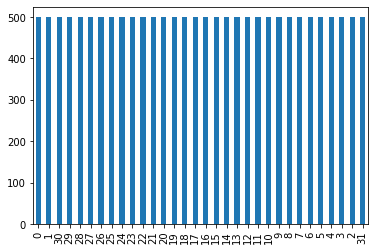

In [29]:
import matplotlib.pyplot as plt

def plot(df):
    df["label"].value_counts().plot(kind = 'bar')

    
def sample(df, max_no_rows=None):
    if max_no_rows is None:
        max_no_rows = min([x[1].shape[0] for x in df.groupby("label")])
    print(f"max no of rows: {max_no_rows}")
    
    def _sample(x):
        # do not undersample if we have less than
#         if x.shape[0] > max_no_rows:
        return x.sample(n=max_no_rows, replace=True, axis=0)
#         return x
    
    df = df.groupby("label", as_index=False).apply(lambda x: _sample(x)).reset_index(drop=True)
    plot(df)
    return df

# _range = [1, 5, 10, 15, 20, 25, 50, 100, 250, 500]
# _range = [1, 5, 10, 15, 20, 25, 50]
# _range = [1, 5, 10, 15, 20]
_range = [25, 50, 100, 250, 500]
# _range = [1000]


df_train = train_dataset.to_pandas()
dataset_dict = {}

for i in _range:
    df_train_few_shot = sample(df=df_train, max_no_rows=i)
    dataset_dict[i] =  Dataset.from_pandas(df_train_few_shot)

dataset_dict

In [30]:
import os
import shutil

for few_shots, train_dataset in dataset_dict.items():

    # fetch a freshc validation dataset
    val_dataset = dataset["validation"]

    # Load Pretrained Model and Processor.
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    config = model.config
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    tokenizer = processor.tokenizer
    feature_extractor = processor.feature_extractor

    MAX_TEXT_LENGTH = 77
    IMAGE_SIZE = config.vision_config.image_size
    
    # Process the Tweets.
    def tokenize_captions(examples):
        captions = [caption for caption in examples[caption_column]]
        text_inputs = tokenizer(captions, max_length=MAX_TEXT_LENGTH, padding="max_length", truncation=True)
        examples["input_ids"] = text_inputs.input_ids
        examples["attention_mask"] = text_inputs.attention_mask
        return examples


    train_dataset = train_dataset.map(
        function=tokenize_captions,
        batched=True,
        remove_columns=[col for col in column_names if col != image_column],
        num_proc=None,
        load_from_cache_file=False,
        desc="Running tokenizer on train dataset",
    )

    val_dataset = val_dataset.map(
        function=tokenize_captions,
        batched=True,
        remove_columns=[col for col in column_names if col != image_column],
        num_proc=None,
        load_from_cache_file=False,
        desc="Running tokenizer on val dataset",
    )

#     test_dataset = test_dataset.map(
#         function=tokenize_captions,
#         batched=True,
#         remove_columns=[col for col in column_names if col != image_column],
#         num_proc=None,
#         load_from_cache_file=False,
#         desc="Running tokenizer on test dataset",
#     )
    
    # Process the Emoji images.
    from PIL import Image

    def transform_images(examples):
        # https://pytorch.org/vision/stable/_modules/torchvision/io/image.html#ImageReadMode
        images = [Image.open(str(Path("./emojis",f"{c}.png"))) for c in examples[image_column]]
        images_transformed = processor.feature_extractor(images, return_tensors="pt")
        examples["pixel_values"] = images_transformed["pixel_values"]
        return examples


    train_dataset.set_transform(transform_images)
    val_dataset.set_transform(transform_images)
#     test_dataset.set_transform(transform_images)


    def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
        attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "return_loss": True,
        }

    
    from datasets import load_metric
    metric = load_metric("precision")

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        return metric.compute(predictions=predictions, references=labels)

    from pathlib import Path
    dir_ = f"./checkpoints-{few_shots}"
    if os.path.exists(dir_):
        shutil.rmtree(dir_)
    Path(dir_).mkdir(parents=True, exist_ok=True)
    trainer = Trainer(
        model=model,
        args=TrainingArguments(output_dir=dir_,
                               dataloader_num_workers=0,
                               # no of emojis
                               per_device_eval_batch_size=32,
                               per_device_train_batch_size=32,
                               num_train_epochs=4,
    # I couldn't make evaluation work.
    #                            evaluation_strategy = "steps",
    #                            eval_steps=8,
                               warmup_steps=0,
                               learning_rate=5e-05,
                               weight_decay=0.1,
                               report_to="wandb",
                               logging_strategy="epoch",
#                                logging_steps=100,
                               save_strategy="epoch"
                               ),
        train_dataset=train_dataset,
        eval_dataset=train_dataset,
        compute_metrics=compute_metrics,
        data_collator=collate_fn,
        tokenizer=processor
    )
    
    train_result = trainer.train()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/snapshots/f330785f9a2435f10d525312e9c0408703b80cfa/config.json
text_config_dict is None. Initializing the CLIPTextConfig with default values.
vision_config_dict is None. initializing the CLIPVisionConfig with default values.
Model config CLIPConfig {
  "_commit_hash": "f330785f9a2435f10d525312e9c0408703b80cfa",
  "_name_or_path": "openai/clip-vit-base-patch32",
  "architectures": [
    "CLIPModel"
  ],
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "clip",
  "projection_dim": 512,
  "text_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropo

Running tokenizer on train dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on val dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

PyTorch: setting up devices
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 800
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 100
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step,Training Loss
25,3.245400
50,2.412700
75,1.545400
100,0.951400


Saving model checkpoint to ./checkpoints-25/checkpoint-25
Configuration saved in ./checkpoints-25/checkpoint-25/config.json
Model weights saved in ./checkpoints-25/checkpoint-25/pytorch_model.bin
Feature extractor saved in ./checkpoints-25/checkpoint-25/preprocessor_config.json
tokenizer config file saved in ./checkpoints-25/checkpoint-25/tokenizer_config.json
Special tokens file saved in ./checkpoints-25/checkpoint-25/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Saving model checkpoint to ./checkpoints-25/checkpoint-50
Configuration saved in ./checkpoints-25/checkpoint-50/config.json
Model weights saved in ./checkpoints-25/checkpoint-50/pytorch_model.bin
Feature extractor saved in ./checkpoints-25/checkpoint-50/preprocessor_config.json
tokenizer config file saved in ./checkpoints-25/checkpoint-50/tokenizer_config.json
Special tokens f

Running tokenizer on train dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Running tokenizer on val dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

PyTorch: setting up devices
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1600
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 200
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step,Training Loss
50,3.320600
100,2.531900
150,1.923600
200,1.365200


Saving model checkpoint to ./checkpoints-50/checkpoint-50
Configuration saved in ./checkpoints-50/checkpoint-50/config.json
Model weights saved in ./checkpoints-50/checkpoint-50/pytorch_model.bin
Feature extractor saved in ./checkpoints-50/checkpoint-50/preprocessor_config.json
tokenizer config file saved in ./checkpoints-50/checkpoint-50/tokenizer_config.json
Special tokens file saved in ./checkpoints-50/checkpoint-50/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Saving model checkpoint to ./checkpoints-50/checkpoint-100
Configuration saved in ./checkpoints-50/checkpoint-100/config.json
Model weights saved in ./checkpoints-50/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./checkpoints-50/checkpoint-100/preprocessor_config.json
tokenizer config file saved in ./checkpoints-50/checkpoint-100/tokenizer_config.json
Special tok

Running tokenizer on train dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

Running tokenizer on val dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

PyTorch: setting up devices
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3200
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 400
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step,Training Loss
100,3.126000
200,2.202400
300,1.529600
400,0.994900


Saving model checkpoint to ./checkpoints-100/checkpoint-100
Configuration saved in ./checkpoints-100/checkpoint-100/config.json
Model weights saved in ./checkpoints-100/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./checkpoints-100/checkpoint-100/preprocessor_config.json
tokenizer config file saved in ./checkpoints-100/checkpoint-100/tokenizer_config.json
Special tokens file saved in ./checkpoints-100/checkpoint-100/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Saving model checkpoint to ./checkpoints-100/checkpoint-200
Configuration saved in ./checkpoints-100/checkpoint-200/config.json
Model weights saved in ./checkpoints-100/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./checkpoints-100/checkpoint-200/preprocessor_config.json
tokenizer config file saved in ./checkpoints-100/checkpoint-200/tokenizer_config

Running tokenizer on train dataset:   0%|          | 0/8 [00:00<?, ?ba/s]

Running tokenizer on val dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

PyTorch: setting up devices
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8000
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step,Training Loss
250,2.198200
500,1.400700
750,0.933000
1000,0.690600


Saving model checkpoint to ./checkpoints-250/checkpoint-250
Configuration saved in ./checkpoints-250/checkpoint-250/config.json
Model weights saved in ./checkpoints-250/checkpoint-250/pytorch_model.bin
Feature extractor saved in ./checkpoints-250/checkpoint-250/preprocessor_config.json
tokenizer config file saved in ./checkpoints-250/checkpoint-250/tokenizer_config.json
Special tokens file saved in ./checkpoints-250/checkpoint-250/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Saving model checkpoint to ./checkpoints-250/checkpoint-500
Configuration saved in ./checkpoints-250/checkpoint-500/config.json
Model weights saved in ./checkpoints-250/checkpoint-500/pytorch_model.bin
Feature extractor saved in ./checkpoints-250/checkpoint-500/preprocessor_config.json
tokenizer config file saved in ./checkpoints-250/checkpoint-500/tokenizer_config

Running tokenizer on train dataset:   0%|          | 0/16 [00:00<?, ?ba/s]

Running tokenizer on val dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

PyTorch: setting up devices
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2000
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step,Training Loss
500,1.918300
1000,1.141900
1500,0.770000
2000,0.616000


Saving model checkpoint to ./checkpoints-500/checkpoint-500
Configuration saved in ./checkpoints-500/checkpoint-500/config.json
Model weights saved in ./checkpoints-500/checkpoint-500/pytorch_model.bin
Feature extractor saved in ./checkpoints-500/checkpoint-500/preprocessor_config.json
tokenizer config file saved in ./checkpoints-500/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./checkpoints-500/checkpoint-500/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Saving model checkpoint to ./checkpoints-500/checkpoint-1000
Configuration saved in ./checkpoints-500/checkpoint-1000/config.json
Model weights saved in ./checkpoints-500/checkpoint-1000/pytorch_model.bin
Feature extractor saved in ./checkpoints-500/checkpoint-1000/preprocessor_config.json
tokenizer config file saved in ./checkpoints-500/checkpoint-1000/tokenizer_c